# TPC-DS Runner + Transplanted UDFs

## Setting up Spark

In [1]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("TPC-DS Loader")
    .master("local[*]")
	.config("spark.driver.memory", "3g")
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/12 16:28:58 WARN Utils: Your hostname, LAPTOP-7ECU52TP, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/12/12 16:28:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/12 16:29:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Setting Up Tables From Generated TPC-DS Data

We use sqlglot to read the DDL provided by TPC-DS and collect schema information. It is worth noting that sqlglot does not preserve information like primary/foreign key constraints or nullability of column values.

In [2]:
from sqlglot import parse_one, exp, parse
from pyspark.sql.types import (
	StructType, StructField, StringType, 
	DateType, TimestampType, IntegerType, 
	DecimalType
)

def to_spark_type(sql_type: str):
	if sql_type.startswith("CHAR"):
		return StringType()
	elif sql_type.startswith("VARCHAR"):
		return StringType()
	elif sql_type.startswith("INT"):
		return IntegerType()
	elif sql_type.startswith("DECIMAL"):
		return DecimalType(7, 2)
	elif sql_type.startswith("TIME"):
		return TimestampType()
	elif sql_type.startswith("DATE"):
		return DateType()
	else:
		return StringType()

ddl_path = "./tpcds-kit/tools/tpcds.sql"
with open(ddl_path) as f:
    sql = f.read()
    # trim leading comments
    sql = "\n".join([line for line in sql.split("\n") if not line.strip().startswith("--")])

schema = {}
for statement in parse(sql):
	if isinstance(statement, exp.Create):
		table_name = statement.this.this.this.this

		columns = []
		for col_def in statement.find_all(exp.ColumnDef):
			col_name = col_def.this.name
			col_type = col_def.args.get("kind").sql()
			spark_type = to_spark_type(col_type)
			columns.append(StructField(col_name, spark_type))

		schema[table_name] = StructType(columns)

all_column_types = set()
for table_cols in schema.values():
	for field in table_cols.fields:
		all_column_types.add(field.dataType)

print(len(schema))
print(all_column_types)

25
{DateType(), IntegerType(), StringType(), DecimalType(7,2), TimestampType()}


In [3]:
def create_table_from_data(table_name: str, data_path: str):
	df = spark.read \
		.option("delimiter", "|") \
		.option("timestampFormat", "HH:mm:ss") \
		.schema(schema[table_name]) \
		.csv(data_path)
	
	df.createOrReplaceTempView(table_name)



In [4]:
import glob
import os

data_dir = "./generated_data" # replace with your directory target used with dsdgen

for path in glob.glob(os.path.join(data_dir, "*.dat")):
	file_name = os.path.basename(path)
	table_name = file_name[:-4]

	create_table_from_data(table_name, path)

spark.sql("SHOW TABLES").count()

25/12/12 16:29:45 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


25

## Running Generated TPC-DS Queries

In [5]:
from pathlib import Path
import time

sql_dir = Path("./processed_queries") # replace with your dir containing split queries.

runnable = []
total_queries = 0
for sql_file in sorted(sql_dir.glob("*.sql")):
	with open(sql_file, "r") as f:
		query = f.read()
	
	total_queries += 1
	if query:
		try:
			start_time = time.time()
			df = spark.sql(query).count()
			runnable.append({
				"query": query,
				"elapsed_time_vanilla": time.time() - start_time,
			})
		except Exception as e:
			print(f"Error executing query from {sql_file}")

Error executing query from processed_queries/query_102.sql


Error executing query from processed_queries/query_15.sql


Error executing query from processed_queries/query_18.sql


Error executing query from processed_queries/query_25.sql
Error executing query from processed_queries/query_26.sql


Error executing query from processed_queries/query_32.sql
Error executing query from processed_queries/query_33.sql


25/12/12 16:31:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 16:31:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 16:31:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 16:31:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 16:31:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 16:31:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 1

Error executing query from processed_queries/query_44.sql
Error executing query from processed_queries/query_45.sql


25/12/12 16:32:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 16:32:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 16:32:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 16:32:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 16:32:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 16:32:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/12 1

Error executing query from processed_queries/query_61.sql


Error executing query from processed_queries/query_65.sql
Error executing query from processed_queries/query_66.sql


Error executing query from processed_queries/query_68.sql


Error executing query from processed_queries/query_7.sql


Error executing query from processed_queries/query_8.sql


Error executing query from processed_queries/query_81.sql


Error executing query from processed_queries/query_89.sql


Error executing query from processed_queries/query_98.sql


In [9]:
print(f"Total queries processed: {total_queries}")
print(f"Total runnable queries: {len(runnable)}")

Total queries processed: 103
Total runnable queries: 85


## Transplanting UDFs

1. We provide `sqlglot` the table schemas and canonical query to produce the query tree with type annotations.
2. We then register some udfs
3. We transplant udf calls into the query tree and obtain the new canonical query
4. We attempt to run the updated canonical query

In [10]:
from sqlglot import parse_one, exp, parse
from sqlglot.schema import MappingSchema
from sqlglot.optimizer import optimize


with open("./tpcds-kit/tools/tpcds.sql") as f:
    sql = f.read()
    sql = "\n".join(
        [line for line in sql.split("\n") if not line.strip().startswith("--")]
    )

map_schema = {}
for statement in parse(sql):
    if isinstance(statement, exp.Create):
        table_name = statement.this.this.this.this

        columns = {}
        for col_def in statement.find_all(exp.ColumnDef):
            col_name = col_def.this.name
            col_type = col_def.args.get("kind").sql()
            columns[col_name] = col_type

        map_schema[table_name] = columns

schema_obj = MappingSchema(map_schema)
# print(map_schema)


### Using Identity Functions as UDFs

The following cells are too demonstrate both the feasibility and impact of UDF transplation by using identity functions. We currently transplant UDFs into top-level ALIAS expressions in the sqlglot type-annotated tree. More specifically, we replace the column being aliased with a function of itself that returns the same type.

$$
	col_a \text{ AS } col_A \rightarrow f(col_a) \text{ AS } col_A \text{ where } Type(col_a) = Type(f(col_a))
$$



In [11]:
from pyspark.sql.functions import udf

@udf(StringType())
def dummy_string(x):
	return x

@udf(IntegerType())
def dummy_integer(x):
	return x

@udf(DecimalType(7, 2))
def dummy_decimal(x):
	return x

@udf(TimestampType())
def dummy_timestamp(x):
	return x

@udf(DateType())
def dummy_date(x):
	return x

spark.udf.register("DUMMY_STRING", dummy_string)
spark.udf.register("DUMMY_INTEGER", dummy_integer)
spark.udf.register("DUMMY_DECIMAL", dummy_decimal)
spark.udf.register("DUMMY_TIMESTAMP", dummy_timestamp)
spark.udf.register("DUMMY_DATE", dummy_date)

25/12/12 16:36:21 WARN SimpleFunctionRegistry: The function dummy_string replaced a previously registered function.
25/12/12 16:36:21 WARN SimpleFunctionRegistry: The function dummy_integer replaced a previously registered function.
25/12/12 16:36:21 WARN SimpleFunctionRegistry: The function dummy_decimal replaced a previously registered function.
25/12/12 16:36:21 WARN SimpleFunctionRegistry: The function dummy_timestamp replaced a previously registered function.
25/12/12 16:36:21 WARN SimpleFunctionRegistry: The function dummy_date replaced a previously registered function.


In [12]:
import numpy as np

def get_dummy_udf(type: str):
	sqlglot_type = type.upper()

	if sqlglot_type.startswith("CHAR"):
		return "dummy_string"
	elif sqlglot_type.startswith("VARCHAR"):
		return "dummy_string"
	elif sqlglot_type.startswith("INT"):
		return "dummy_integer"
	elif sqlglot_type.startswith("DECIMAL"):
		return "dummy_decimal"
	elif sqlglot_type.startswith("TIME"):
		return "dummy_timestamp"
	elif sqlglot_type.startswith("DATE"):
		return "dummy_date"
	else:
		return ""


successful_queries = 0
for q in runnable:
	query = q["query"]

	parsed = parse_one(query)
	optimized = optimize(parsed, schema=schema_obj)

	if isinstance(optimized, exp.CTE):
		main_query = optimized.this
	else:
		main_query = optimized

	for select in main_query.find_all(exp.Select):
		new_expressions = []

		for expr in select.expressions:
			if isinstance(expr, exp.Alias) and isinstance(expr.this, exp.Column):
				alias_name = expr.alias
				column_name = expr.this.name
				column_type = expr.this._type.sql()

				dummy_udf = get_dummy_udf(column_type)
				if dummy_udf:
					udf_node = exp.Anonymous(this=dummy_udf, expressions=[expr.this.copy()])
					alias_node = exp.Alias(this=udf_node, alias=alias_name)
					new_expressions.append(alias_node)
				else:
					new_expressions.append(expr)
			else:
				new_expressions.append(expr)

		select.set("expressions", new_expressions)
	
	# new_query = optimized.sql(pretty=True)
	try:
		new_query = optimized.sql(pretty=True).replace('\"', '')
		start = time.time()
		df = spark.sql(new_query).count()
		q["elapsed_time_identity_udfs"] = time.time() - start
		successful_queries += 1
	except Exception as e:
		q["elapsed_time_identity_udfs"] = np.nan
	

25/12/12 16:39:04 ERROR Executor: Exception in task 13.0 in stage 1613.0 (TID 6310)
org.apache.spark.SparkArithmeticException: [NUMERIC_VALUE_OUT_OF_RANGE.WITHOUT_SUGGESTION]  The 116698.98 rounded half up from 116698.98 cannot be represented as Decimal(7, 2). SQLSTATE: 22003
	at org.apache.spark.sql.types.Decimal.set(Decimal.scala:130)
	at org.apache.spark.sql.types.Decimal$.apply(Decimal.scala:608)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$$nestedInanonfun$makeFromJava$8$1.applyOrElse(EvaluatePython.scala:134)
	at org.apache.spark.sql.execution.python.EvaluatePython$.nullSafeConvert(EvaluatePython.scala:221)
	at org.apache.spark.sql.execution.python.EvaluatePython$.$anonfun$makeFromJava$8(EvaluatePython.scala:133)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$$nestedInanonfun$makeFromJava$16$1.applyOrElse(EvaluatePython.scala:196)
	at org.apache.spark.sql.execution.python.EvaluatePython$.nullSafeConvert(EvaluatePython.scala:221)
	at org.apa

In [13]:
print(f"UDF transplant success rate: {successful_queries} / {len(runnable)}")

UDF transplant success rate: 83 / 85


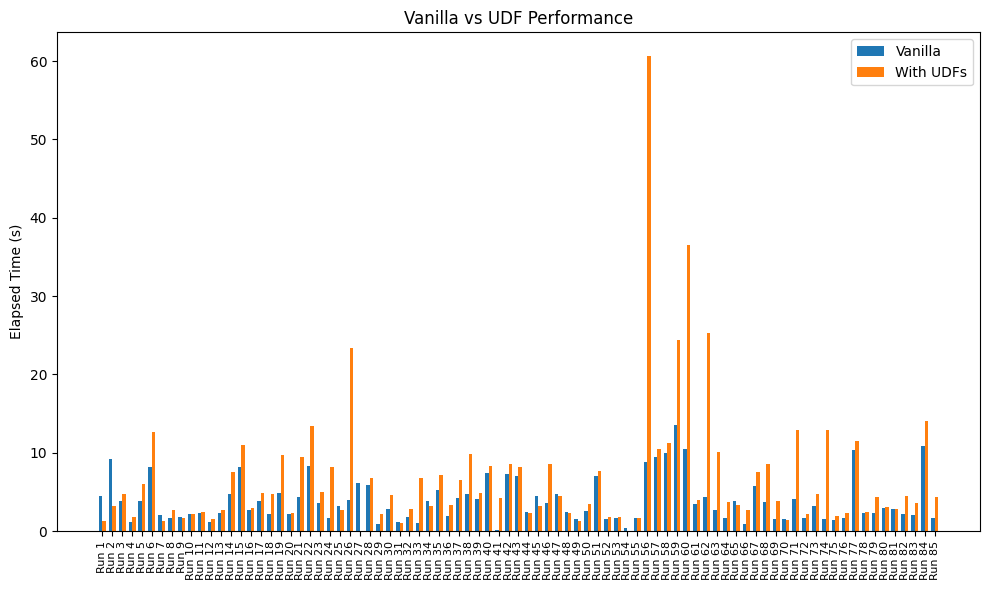

In [14]:
import matplotlib.pyplot as plt

vanilla_times = [r["elapsed_time_vanilla"] for r in runnable]
udf_times = [r["elapsed_time_identity_udfs"] for r in runnable]

x = np.arange(len(vanilla_times))  # x-axis positions
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width/2, vanilla_times, width, label='Vanilla')
ax.bar(x + width/2, udf_times, width, label='With UDFs')

ax.set_xticks(x)
ax.set_xticklabels([f"Run {i+1}" for i in x], rotation=90, fontsize=8)

ax.set_ylabel("Elapsed Time (s)")
ax.set_title("Vanilla vs UDF Performance")
ax.legend()

plt.tight_layout()
plt.show()

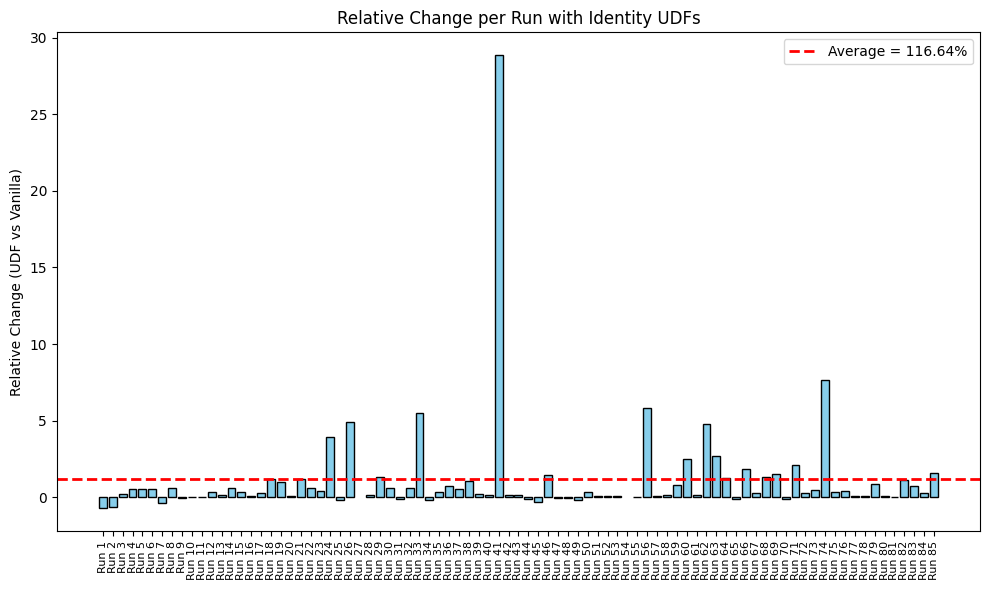

In [15]:
relative_change = [(u - v)/v for u, v in zip(udf_times, vanilla_times)]

avg_change = np.nanmean(relative_change)

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.bar(x, relative_change, color='skyblue', edgecolor='black')
ax.axhline(avg_change, color='red', linestyle='--', linewidth=2, label=f'Average = {avg_change:.2%}')

ax.set_xticks(x)
ax.set_xticklabels([f"Run {i+1}" for i in x], rotation=90, fontsize=8)

ax.set_ylabel("Relative Change (UDF vs Vanilla)")
ax.set_title("Relative Change per Run with Identity UDFs")
ax.legend()

plt.tight_layout()
plt.show()

### Using Some Scraped UDFs

In [16]:
# Scraped source:
# https://github.com/ericxiao251/spark-syntax/blob/master/src/Chapter%202%20-%20Exploring%20the%20Spark%20APIs/Section%202.10%20-%20Spark%20Functions%20aren't%20Enough%2C%20I%20Need%20my%20Own!.ipynb
def _uppercase_words(word, cutoff_length):
	return word.upper()[:cutoff_length] if word else None

spark.udf.register("UPPERCASE_WORDS", lambda x: _uppercase_words(x, 5), StringType())

# Scraped source:
# https://github.com/PacktPublishing/Mastering-Big-Data-Analytics-with-PySpark/blob/master/Section%206%20-%20Analyzing%20Big%20Data/6.3/data_wrangling.ipynb
import html
def _html_unescape(s):
	if isinstance(s, str):
		return html.unescape(s)
	return s
spark.udf.register("HTML_UNESCAPE", _html_unescape, StringType())

# Scraped source:
# https://github.com/mahmoudparsian/big-data-mapreduce-course/blob/master/slides/pyspark/UDF/dataframe_UDF_example.py
def _convert_case(name):
	if name is None:
		return None
	if len(name) < 1:
		return ""
	
	result_string = ""
	arr = name.split(" ")
	for x in arr:
		result_string += x[0:1].upper() + x[1:len(x)] + " "
	return result_string.strip()
spark.udf.register("CONVERT_CASE", _convert_case, StringType())

# Scraped source:
# https://github.com/Azure/PySpark-Predictive-Maintenance/blob/master/Notebook_1_DataCleansing_FeatureEngineering.ipynb
def _negative_replace(num):
	if num is None:
		return None
	if num < 0:
		return 0
	return num
spark.udf.register("NEGATIVE_REPLACE", _negative_replace, IntegerType())

# Scraped source:
# https://github.com/PacktPublishing/50-Hours-of-Big-Data-PySpark-AWS-Scala-and-Scraping/blob/main/Part%203/Code/03-Spark%20DFs/27-Spark%20DF%20(UDFs).py
def _total_salary(salary):
	if salary is None:
		return None
	return salary + 100
spark.udf.register("TOTAL_SALARY", _total_salary, IntegerType())

from decimal import Decimal
def _kw_only_scale(a, scale):
	if a is None:
		return None
	return a * scale
spark.udf.register(
	"KW_ONLY_SCALE", 
	lambda x: Decimal(_kw_only_scale(x, 10)) if x is not None else None, 
	DecimalType()
)

def _square(n):
	if n is None:
		return None
	return n * n
spark.udf.register("SQUARE", _square, IntegerType())

udf_pool = {
	"VARCHAR": ["UPPERCASE_WORDS", "HTML_UNESCAPE", "CONVERT_CASE"],
	"INT": ["NEGATIVE_REPLACE", "TOTAL_SALARY", "SQUARE"],
	"DECIMAL": ["KW_ONLY_SCALE"],
	"CHAR": ["UPPERCASE_WORDS", "HTML_UNESCAPE", "CONVERT_CASE"],
}

In [17]:
import random

successful_queries = 0
for q in runnable:
	query = q["query"]

	parsed = parse_one(query)
	optimized = optimize(parsed, schema=schema_obj)

	if isinstance(optimized, exp.CTE):
		main_query = optimized.this
	else:
		main_query = optimized

	for select in main_query.find_all(exp.Select):
		new_expressions = []

		for expr in select.expressions:
			if isinstance(expr, exp.Alias) and isinstance(expr.this, exp.Column):
				alias_name = expr.alias
				column_name = expr.this.name
				column_type = expr.this._type.sql()

				possible_udfs = udf_pool.get(column_type.upper().split("(")[0], [])
				if possible_udfs:
					dummy_udf = random.choice(possible_udfs)
					udf_node = exp.Anonymous(this=dummy_udf, expressions=[expr.this.copy()])
					alias_node = exp.Alias(this=udf_node, alias=alias_name)
					new_expressions.append(alias_node)
				else:
					new_expressions.append(expr)
			else:
				new_expressions.append(expr)

		select.set("expressions", new_expressions)
	
	# new_query = optimized.sql(pretty=True)
	try:
		new_query = optimized.sql(pretty=True).replace('\"', '')
		start = time.time()
		df = spark.sql(new_query).count()
		q["elapsed_time_advanced_udfs"] = time.time() - start
		successful_queries += 1
	except Exception as e:
		q["elapsed_time_advanced_udfs"] = np.nan

25/12/12 16:50:15 ERROR Executor: Exception in task 3.0 in stage 2861.0 (TID 11144)
org.apache.spark.SparkArithmeticException: [NUMERIC_VALUE_OUT_OF_RANGE.WITHOUT_SUGGESTION]  The 10034258804 rounded half up from 10034258803.70 cannot be represented as Decimal(10, 0). SQLSTATE: 22003
	at org.apache.spark.sql.types.Decimal.set(Decimal.scala:130)
	at org.apache.spark.sql.types.Decimal$.apply(Decimal.scala:608)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$$nestedInanonfun$makeFromJava$8$1.applyOrElse(EvaluatePython.scala:134)
	at org.apache.spark.sql.execution.python.EvaluatePython$.nullSafeConvert(EvaluatePython.scala:221)
	at org.apache.spark.sql.execution.python.EvaluatePython$.$anonfun$makeFromJava$8(EvaluatePython.scala:133)
	at org.apache.spark.sql.execution.python.EvaluatePython$$anonfun$$nestedInanonfun$makeFromJava$16$1.applyOrElse(EvaluatePython.scala:196)
	at org.apache.spark.sql.execution.python.EvaluatePython$.nullSafeConvert(EvaluatePython.scala:221)
	at

In [18]:
print("Successful advanced UDF queries:", successful_queries, "/", len(runnable))

Successful advanced UDF queries: 83 / 85


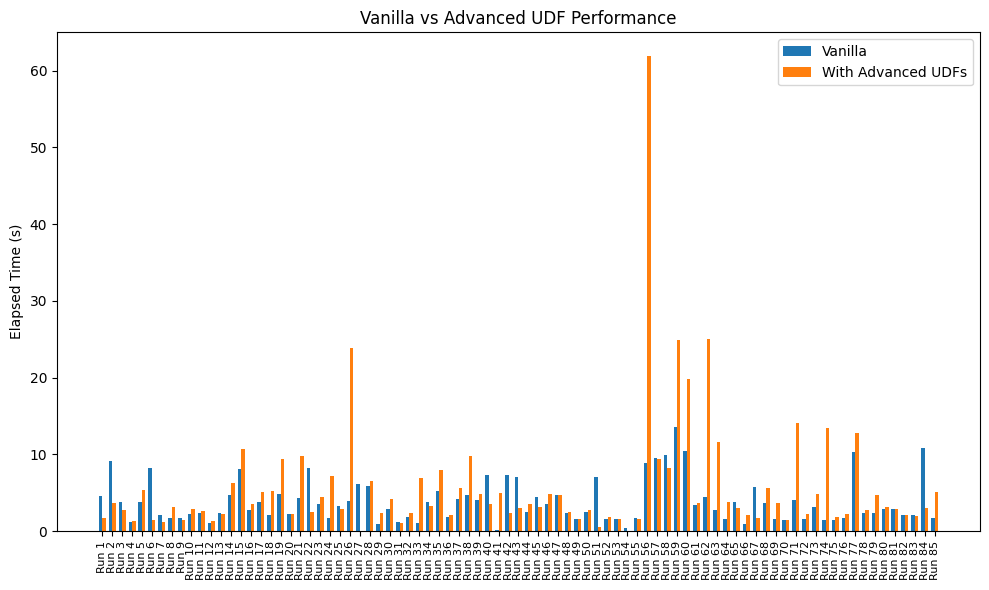

In [19]:
vanilla_times = [r["elapsed_time_vanilla"] for r in runnable]
udf_times = [r["elapsed_time_advanced_udfs"] for r in runnable]

x = np.arange(len(vanilla_times))  # x-axis positions
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, vanilla_times, width, label='Vanilla')
ax.bar(x + width/2, udf_times, width, label='With Advanced UDFs')

ax.set_xticks(x)
ax.set_xticklabels([f"Run {i+1}" for i in x], rotation=90, fontsize=8)
ax.set_ylabel("Elapsed Time (s)")
ax.set_title("Vanilla vs Advanced UDF Performance")
ax.legend()

plt.tight_layout()
plt.show()

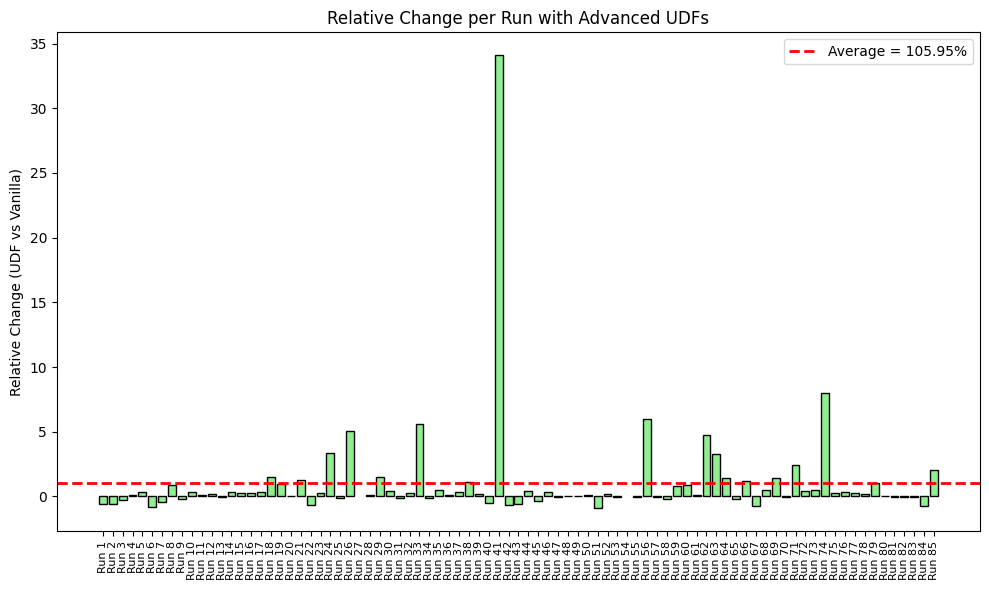

In [20]:
relative_change = [(u - v)/v for u, v in zip(udf_times, vanilla_times)]
avg_change = np.nanmean(relative_change)

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(x, relative_change, color='lightgreen', edgecolor='black')
ax.axhline(avg_change, color='red', linestyle='--', linewidth=2, label=f'Average = {avg_change:.2%}')
ax.set_xticks(x)
ax.set_xticklabels([f"Run {i+1}" for i in x], rotation=90, fontsize=8)
ax.set_ylabel("Relative Change (UDF vs Vanilla)")
ax.set_title("Relative Change per Run with Advanced UDFs")
ax.legend()

plt.tight_layout()
plt.show()